In [ ]:
#%matplotlib notebook

# Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
#import plotly.express as px
#import plotly.colors as pcolors

import random
#from skyfield.api import Topos, load, EarthSatellite
import datetime as dt
import math as m
# import cartopy.crs as ccrs
#import kaleido

In [ ]:
mpl.rcdefaults()

In [ ]:
mpl.rcParams['figure.dpi'] = 300

In [ ]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                             using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

column_width = 426.0  # Column width (pt) in LaTeX

# Load Space-Track dataset

In [ ]:
def get_space_track_dataframe(dataset_path, reduced=False, frac1=0.25, reduced_sample_alt_e=False, frac2=1.0,
                              min_alt=500,
                              max_alt=520, e_thres=0.25, sampled1=False, reduced_sample_leos=False, frac3=0.25,
                              leo='leo4', sampled2=True):
    # Determine the file path based on conditions
    if reduced:
        filepath = f"{dataset_path}datasets/space-track-dataset-reduced-{int(frac1 * 100)}.csv"
    elif reduced_sample_alt_e:
        if sampled1:
            filepath = f"{dataset_path}datasets/space-track-dataset-reduced-{int(frac2 * 100)}-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.csv"
        else:
            filepath = f"{dataset_path}datasets/space-track-dataset-reduced-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.csv"
    elif reduced_sample_leos:
        if sampled2:
            filepath = f"{dataset_path}datasets/space-track-dataset-{leo}-reduced-{int(frac3 * 100)}.csv"
        else:
            filepath = f"{dataset_path}datasets/space-track-dataset-{leo}.csv"
    else:
        filepath = f'{dataset_path}datasets/space-track-dataset.csv'

    # Read the CSV file into a DataFrame
    st_df = pd.read_csv(filepath, memory_map=True,
                        usecols=['NORAD_CAT_ID', 'EPOCH_DATE', 'EPOCH_TIME', 'MEAN_MOTION', 'ECCENTRICITY',
                                 'INCLINATION', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'REV_AT_EPOCH',
                                 'BSTAR', 'MEAN_MOTION_DOT', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS',
                                 'OBJECT_TYPE', 'RCS_SIZE'])
    st_df['EPOCH_TIME'] = st_df['EPOCH_TIME'].apply(lambda t: t.split('.')[0])
    st_df['TIMESTAMP'] = st_df['EPOCH_DATE'] + ' ' + st_df['EPOCH_TIME']

    print(f"Space-Track dataset loaded from: {filepath}")
    # Return the dataframe
    return st_df


st_df = get_space_track_dataframe(dataset_path='../', reduced_sample_alt_e=True)
st_df.head()

In [ ]:
st_df.describe()

In [ ]:
st_df.NORAD_CAT_ID.unique().shape[0]

## Load ESA DISCOS satellite dataset

In [ ]:
esa_df = pd.read_csv('../datasets/esa-discos-satellite-data.csv', usecols=['satno', 'name', 'constellationDiscosID'],
                     memory_map=True)
print(f"Number of constellations: {esa_df['constellationDiscosID'].unique().shape[0]}")
esa_df.head()

## Extend Space-Track dataset with DISCOS constellation ID for each satellite in Space-Track dataset

In [ ]:
df = pd.merge(st_df, esa_df, how='left', left_on='NORAD_CAT_ID', right_on='satno').drop('satno', axis=1).rename(
    columns={'constellationDiscosID': 'CONSTELLATION_DISCOS_ID', 'name': 'CONSTELLATION_NAME'}).fillna(
    {'CONSTELLATION_DISCOS_ID': 0})
df['CONSTELLATION_DISCOS_ID'] = df['CONSTELLATION_DISCOS_ID'].astype(int)
df.columns

In [ ]:
print(f"Number of constellations: {df['CONSTELLATION_DISCOS_ID'].unique().shape[0]}")
df.head()

## Load Space-Track AP2 graph node features

In [ ]:
def get_nodes_dataframe(dataset_path, reduced=False, frac1=0.25, reduced_sample_alt_e=False, frac2=1.0, min_alt=500,
                        max_alt=520,
                        e_thres=0.25, sampled1=False, reduced_sample_leos=True, frac3=0.25, leo='leo4', sampled2=True):
    # Determine the file path based on conditions
    if reduced:
        nodes_savepath = f"{dataset_path}datasets/space-track-ap2-graph-node-feats-reduced-{int(frac1 * 100)}.csv"
    elif reduced_sample_alt_e:
        if sampled1:
            nodes_savepath = f"{dataset_path}datasets/space-track-ap2-graph-node-feats-reduced-{int(frac2 * 100)}-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.csv"
        else:
            nodes_savepath = f"{dataset_path}datasets/space-track-ap2-graph-node-feats-reduced-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.csv"
    elif reduced_sample_leos:
        if sampled2:
            nodes_savepath = f"{dataset_path}datasets/space-track-ap2-graph-node-feats-{leo}-reduced-{int(frac3 * 100)}.csv"
        else:
            nodes_savepath = f"{dataset_path}datasets/space-track-ap2-graph-node-feats-{leo}.csv"
    else:
        nodes_savepath = f'{dataset_path}datasets/space-track-ap2-graph-node-feats.csv'

    # Read the CSV file and clean the data
    nodes_df = pd.read_csv(nodes_savepath, memory_map=True,
                           usecols=['NORAD_CAT_ID', 'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE',
                                    'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT',
                                    'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS',
                                    'OBJECT_TYPE', 'RCS_SIZE', 'CONSTELLATION_DISCOS_ID', 'PX', 'PY', 'PZ',
                                    'VX', 'VY', 'VZ', 'TIMESTAMP']).set_index('NORAD_CAT_ID').fillna(
        {'CONSTELLATION_DISCOS_ID': 0})

    print(f"Space-Track AP2 graph node features loaded from: {nodes_savepath}")

    nodes_df[['EPOCH_DATE', 'EPOCH_TIME']] = nodes_df['TIMESTAMP'].str.split(' ', expand=True)
    nodes_df['CONSTELLATION_DISCOS_ID'] = nodes_df['CONSTELLATION_DISCOS_ID'].astype(int)
    # Return the dataframe
    return nodes_df


nodes_df = get_nodes_dataframe(dataset_path='../', )
nodes_df.head()

In [ ]:
nodes_df.index.unique().shape

# Exploratory Data Analysis

In [ ]:
orbital_units = {
    "MEAN_MOTION": "rev/day",
    "ECCENTRICITY": "",
    "INCLINATION": "degrees",
    "RA_OF_ASC_NODE": "degrees",
    "ARG_OF_PERICENTER": "degrees",
    "MEAN_ANOMALY": "degrees",
    "BSTAR": "earth radii^-1",
    "MEAN_MOTION_DOT": "rev/day^2",
    "MEAN_MOTION_DDOT": "rev/day^3",
    "SEMIMAJOR_AXIS": "km",
    "PERIOD": "minutes",
    "APOAPSIS": "km",
    "PERIAPSIS": "km"
}

In [ ]:
numerical_columns = df.select_dtypes(include='float').columns
categorical_columns = df.select_dtypes(include=['object', 'int']).columns.drop(
    ['NORAD_CAT_ID', 'REV_AT_EPOCH', 'TIMESTAMP', 'EPOCH_DATE', 'EPOCH_TIME', 'CONSTELLATION_NAME'])
log_scale_columns = ['ECCENTRICITY', 'BSTAR', 'MEAN_MOTION_DOT']

In [ ]:
# Plotting Configuration
sns.set(style="whitegrid")
sns.set_palette("colorblind")

In [ ]:
df.columns

# Distribution of categorical column

In [ ]:
def plot_catcol_distribution(df, column, save_path='../figures/satcon/', figsize=(8, 5), save=False, plot_title=True,
                             show=False):
    # Create a bar plot
    plt.figure(figsize=figsize)
    df_col = df[column]
    abs_values = df_col.value_counts(ascending=False)
    ax = sns.countplot(x=df_col, order=abs_values.index, stat='percent', alpha=1)

    rel_values = df_col.value_counts(ascending=False, normalize=True).values * 100
    lbls = [f'{p:.1f}%' for p in rel_values]

    ax.bar_label(container=ax.containers[0], labels=lbls)

    # Create the title based on the column name
    column_title = column.replace('_', ' ').title()
    title = 'Distribution of ' + column_title

    if plot_title:
        plt.title(title)
    # Set plot labels and title
    plt.xlabel(column_title, fontsize=12)
    plt.xticks(fontsize=11)
    plt.ylabel('Percentage of Space Objects')
    plt.tight_layout()

    # Save the plot to the specified path
    if save:
        plt.savefig(f"{save_path}eda_satcon_{'_'.join(title.lower().split())}.pdf", format='pdf')

    # Display the plot
    if show:
        plt.show()
    plt.close()

column = 'CONSTELLATION_DISCOS_ID'
plot_catcol_distribution(df, column,figsize=get_figsize(column_width, wf=0.85, hf=0.8), show=True, plot_title=False, save=True)

# Distribution of categorical column by another categorical column

In [ ]:
def plot_catcat_distribution(df, main_column, secondary_column, save_path='../figures/satcon/', figsize=(8, 5), save=False,
                             plot_title=True, show=False):
    # Create the subset of the dataframe with the selected columns
    df_col = df[[main_column, secondary_column]]

    # Set up the figure size
    plt.figure(figsize=figsize)

    # Create the count plot
    sns.countplot(x=main_column, hue=secondary_column, data=df_col, palette='tab10', log_scale=False)

    # Format titles
    main_column_title = main_column.replace('_', ' ').title()
    secondary_column_title = secondary_column.replace('_', ' ').title()
    title = f'{main_column_title} Distribution by {secondary_column_title}'

    # Set plot title and labels
    if plot_title:
        plt.title(title)
    plt.xlabel(main_column_title)
    plt.ylabel('Number of Space Objects')

    # Set legend
    plt.legend(title=secondary_column_title)

    # Adjust layout
    plt.tight_layout()

    # Save the plot as a PDF
    if save:
        plt.savefig(f'{save_path}eda_satcon_{"_".join(title.lower().split())}.pdf', format='pdf')

    # Display the plot
    if show:
        plt.show()
    plt.close()


main_column = 'RCS_SIZE'
secondary_column = 'CONSTELLATION_DISCOS_ID'
plot_catcat_distribution(df, main_column, secondary_column, show=True, save=False)

# Evolution of a categorical column count over time

In [ ]:
def plot_catcol_evolution_day(df, column, save_path='../figures/satcon/', figsize=(8, 6), save=False, plot_title=True,
                              show=False):
    # Prepare the column title
    column_title = column.replace('_', ' ').title()

    # Convert 'EPOCH_DATE' to datetime if it's not already in datetime format
    df['EPOCH_DATE'] = pd.to_datetime(df['EPOCH_DATE'])

    # Create a unique subset of the dataframe
    df_unique = df[['NORAD_CAT_ID', 'EPOCH_DATE', column]].drop_duplicates()
    df_unique['EPOCH_DATE'] = df_unique['EPOCH_DATE'].dt.to_period('D')

    # Group by 'EPOCH_DATE' and 'OBJECT_TYPE' to get the counts of each type per date
    df_grouped = df_unique.groupby(['EPOCH_DATE', column]).size().reset_index(name='count')

    # Convert the 'EPOCH_DATE' back to datetime for plotting
    df_grouped['EPOCH_DATE'] = df_grouped['EPOCH_DATE'].dt.to_timestamp()

    # Set up the figure size
    plt.figure(figsize=figsize)

    # Create the line plot for count evolution
    sns.lineplot(x='EPOCH_DATE', y='count', hue=column, data=df_grouped, palette='tab10')

    # Format the title
    title = f'Evolution of {column_title} per Day'

    # Set plot title and labels
    if plot_title:
        plt.title(title)
    plt.xlabel('Epoch Date')
    plt.ylabel('Number of Space Objects')

    # Rotate the x-ticks for better readability
    plt.xticks(df_grouped['EPOCH_DATE'].unique(), rotation=45)
    
    plt.legend(title=column_title, fontsize='small')
    # plt.legend(title=column_title, loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    # plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Save the plot as a PDF
    if save:
        plt.savefig(f'{save_path}eda_satcon_{"_".join(title.lower().split())}.pdf', format='pdf')

    # Display the plot
    if show:
        plt.show()
    plt.close()


column = 'CONSTELLATION_DISCOS_ID'
plot_catcol_evolution_day(df, column, show=True)

## Distribution of a numeric column

In [ ]:
parameters = numerical_columns
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))  # Adjust nrows and ncols based on the number of parameters
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Plot each parameter in a separate subplot
for i, param in enumerate(parameters):
    if param in df.columns:
        log_scale = param in log_scale_columns
        sns.histplot(df[param], bins=30, ax=axes[i], log_scale=log_scale)
        axes[i].set_title(f'Distribution of {param}')
        axes[i].set_xlabel(
            f'log({param}) ({orbital_units[param]})' if log_scale else f'{param} ({orbital_units[param]})')
        axes[i].set_ylabel('Frequency')

# Remove any unused subplots (if fewer parameters than subplots)
for j in range(len(parameters), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
def plot_numcol_histogram(df, column, bins=30, unit="", log_scale=False, save_path='../figures/satcon/', figsize=(8, 5),
                          save=False,
                          plot_title=True):
    # Set up the figure size
    plt.figure(figsize=figsize)

    # Create the histogram with KDE
    sns.histplot(df[column], log_scale=log_scale, bins=bins, alpha=1, stat='percent')
    # Format the column title
    column_title = column.replace('_', ' ').title()
    if column == 'RA_OF_ASC_NODE':
        column_title = 'RAAN'
    if column == 'ARG_OF_PERICENTER':
        column_title = 'Argument of Pericenter'
    if column == 'MEAN_MOTION_DOT':
        column_title = 'MM 1st Derivative'
    title = f'Distribution of {column_title}'

    # Set plot title and labels
    if plot_title:
        plt.title(title)

    if log_scale:
        column_title = f'log({column_title})'
    plt.xlabel(f'{column_title} ({unit})' if unit != '' else column_title)
    plt.ylabel('Percentage of\n Space Objects')
    # Adjust layout
    plt.tight_layout()

    # Save the plot as a PDF
    if save:
        plt.savefig(f'{save_path}eda_satcon_{"_".join(title.lower().split())}.pdf', format='pdf')

    # Display the plot
    plt.show()


column = 'RA_OF_ASC_NODE'
if column == 'INCLINATION':
    bins = 7
elif column in ['MEAN_MOTION', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS']:
    bins = 5
else:
    bins = 30
plot_numcol_histogram(df, column, bins=bins, unit=orbital_units[column], log_scale=column in log_scale_columns, plot_title=False, save=True, figsize=get_figsize(column_width, wf=0.6, hf=0.7))

In [ ]:
get_figsize(column_width, wf=0.5, hf=1.0)

In [ ]:
def plot_numcol_violinplot(df, column, unit="", log_scale=False, nodes_df=None, save_path='../figures/satcon/', figsize=(8, 5),
                        save=False,
                        plot_title=True):
    # Set up the figure size
    plt.figure(figsize=figsize)

    # Format the column title
    column_title = column.replace('_', ' ').title()
    title = f'Violin Plot of {column_title}'

    # Prepare data for boxplot
    if nodes_df is not None:
        # Concatenate both datasets into a single DataFrame
        data1 = df[column].values
        data2 = nodes_df[column].values

        combined_data = pd.DataFrame({
            'Values': np.concatenate([data1, data2]),
            'Dataset': ['Original'] * len(data1) + ['Propagated'] * len(data2)
        })
        sns.violinplot(hue='Dataset', y='Values', data=combined_data, log_scale=log_scale, split=True, gap=.05)
    else:
        sns.violinplot(df[column], log_scale=log_scale, split=True)

    # Set plot title and labels
    if plot_title:
        plt.title(title.replace('Violin Plot', 'Distribution'))
    if log_scale:
        column_title = f'log({column_title})'
    plt.xlabel('')
    plt.ylabel(f'{column_title} ({unit})' if unit != '' else column_title)

    # Adjust layout
    plt.tight_layout()

    # Save the plot as a PDF
    if save:
        plt.savefig(f'{save_path}eda_satcon_{"_".join(title.lower().split())}.pdf', format='pdf')

    # Display the plot
    plt.show()


column = 'MEAN_MOTION_DOT'
plot_numcol_violinplot(df, column, unit=orbital_units[column], log_scale=column in log_scale_columns, nodes_df=None)

In [ ]:
df['BSTAR'].hasnans

In [ ]:
for numerical_column in numerical_columns:
    if numerical_column not in ['MEAN_MOTION_DOT', 'BSTAR']:
        print(f'{numerical_column}')
        

# Distribution of a numerical column by another categorical column

In [ ]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))  # Adjust nrows and ncols based on the number of parameters
axes = axes.flatten()  # Flatten the 2D array of axes to 1D
categorical_column = 'OBJECT_TYPE'
# Plot each parameter in a separate subplot
for i, param in enumerate(parameters):
    if param in df.columns:
        log_scale = param in log_scale_columns
        sns.histplot(x=param, hue=categorical_column, data=df, ax=axes[i], log_scale=log_scale, multiple='stack')
        axes[i].set_title(f'Distribution of {param}')
        axes[i].set_xlabel(
            f'log({param}) ({orbital_units[param]})' if log_scale else f'{param} ({orbital_units[param]})')
        axes[i].set_ylabel('Frequency')

# Remove any unused subplots (if fewer parameters than subplots)
for j in range(len(parameters), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
def plot_numcat_histogram(df, numerical_column, categorical_column, unit='', log_scale=False, save_path='../figures/satcon/',
                          figsize=(8, 5),
                          save=False, plot_title=True):
    # Set up the figure size
    plt.figure(figsize=figsize)

    # Format the column titles
    numerical_column_title = numerical_column.replace('_', ' ').title()
    categorical_column_title = categorical_column.replace('_', ' ').title()
    title = f'Distribution of {numerical_column_title} by {categorical_column_title}'

    # Create the histogram with KDE
    sns.histplot(x=numerical_column, hue=categorical_column, data=df, multiple='stack', log_scale=log_scale)

    # Set the plot title and labels
    if plot_title:
        plt.title(title)
    if log_scale:
        numerical_column_title = f'log({numerical_column_title})'
    plt.xlabel(f'{numerical_column_title} ({unit})' if unit != '' else numerical_column_title)
    plt.ylabel('Number of Space Objects')

    # Adjust layout
    plt.tight_layout()

    # Save the plot as a PDF
    if save:
        plt.savefig(f'{save_path}eda_satcon_{"_".join(title.lower().split())}.pdf', format='pdf')

    # Display the plot
    plt.show()


numerical_column = 'MEAN_MOTION_DOT'
categorical_column = 'OBJECT_TYPE'
plot_numcat_histogram(df, numerical_column, categorical_column, unit=orbital_units[numerical_column],
                      log_scale=numerical_column in log_scale_columns)

In [ ]:
def plot_numcat_violinplot(df, numerical_column, categorical_column, nodes_df=None, unit='', log_scale=False,
                        save_path='../figures/satcon/', figsize=(10, 7), save=False, plot_title=True):
    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=figsize)

    # Format the column titles
    numerical_column_title = numerical_column.replace('_', ' ').title()
    categorical_column_title = categorical_column.replace('_', ' ').title()
    title = f'Violin Plot of {numerical_column_title} by {categorical_column_title}'

    if nodes_df is not None:
        # Combine data without explicit copying: slice and assign the new column on the fly
        combined_data = pd.concat([
            df.loc[:, [categorical_column, numerical_column]].assign(Dataset='Original'),
            nodes_df.loc[:, [categorical_column, numerical_column]].assign(Dataset='Propagated')
        ], ignore_index=True)
        sns.violinplot(x=categorical_column, y=numerical_column, hue='Dataset', data=combined_data, ax=ax,
                       log_scale=log_scale, split=True, gap=.1)
        # Place the legend just outside the plot (to the right)
        ax.legend(title='Dataset', loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    else:
        sns.violinplot(x=categorical_column, y=numerical_column, data=df, ax=ax, log_scale=log_scale, split=True)

    if plot_title:
        ax.set_title(title.replace('Violin Plot', 'Distribution'))
    ax.set_xlabel(categorical_column_title)

    if log_scale:
        numerical_column_title = f'log({numerical_column_title})'
    ax.set_ylabel(f'{numerical_column_title} ({unit})' if unit != '' else numerical_column_title)

    

    # Adjust layout to leave space on the right for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    if save:
        fig.savefig(f'{save_path}eda_satcon_{"_".join(title.lower().split())}_2.pdf', format='pdf')
    plt.show()


numerical_column = 'SEMIMAJOR_AXIS'
categorical_column = 'OBJECT_TYPE'
plot_numcat_violinplot(df, numerical_column, categorical_column, nodes_df=None, unit=orbital_units[numerical_column],
                    log_scale=numerical_column in log_scale_columns, save=True)

In [ ]:
numerical_columns

# Scatter plot of one numeric column vs. another numeric column

In [ ]:
df.columns

In [ ]:
def plot_numnumcat_scatter(df, x_column, y_column, categorical_column, x_unit='', y_unit='', x_log_scale=False, y_log_scale=False,
                 save_path='../figures/satcon/', figsize=(8, 5), alpha=0.5,
                 save=False, plot_title=True):
    # Set up the figure size
    plt.figure(figsize=figsize)

    x_column_title = x_column.replace('_', ' ').title()
    y_column_title = y_column.replace('_', ' ').title()
    categorical_column_title = categorical_column.replace('_', ' ').title()

    # Construct the title using the x and y columns and the hue
    title = f'Scatter plot of {x_column_title} vs {y_column_title} by {categorical_column_title}'

    # Create the scatter plot with specified alpha transparency
    if x_log_scale:
        df[f'{x_column}_log'] = np.log(df[x_column])
        x_column = f'{x_column}_log'
        x_column_title = f'log({x_column_title})'
    if y_log_scale:
        df[f'{y_column}_log'] = np.log(df[y_column])
        y_column = f'{y_column}_log'
        y_column_title = f'log({y_column_title})'
    sns.scatterplot(x=x_column, y=y_column, hue=categorical_column, data=df, alpha=alpha, )

    # Set the plot title and labels if required
    if plot_title:
        plt.title(title.replace('Scatter plot of ', ''))

    plt.xlabel(f'{x_column_title} ({x_unit})' if x_unit != '' else x_column_title)
    plt.ylabel(f'{y_column_title} ({y_unit})' if y_unit != '' else y_column_title)

    # Adjust layout for a neat appearance
    plt.tight_layout()

    # Save the plot as a PDF using a similar naming convention if requested
    if save:
        plt.savefig(f'{save_path}eda_satcon_{"_".join(title.lower().split())}.pdf', format='pdf')

    # Display the plot
    plt.show()


x_column = 'MEAN_MOTION_DOT'
y_column = 'ECCENTRICITY'
categorical_column = 'OBJECT_TYPE'
plot_numnumcat_scatter(df, x_column, y_column, categorical_column, x_unit=orbital_units[x_column], y_unit=orbital_units[y_column],
             x_log_scale=x_column in log_scale_columns, y_log_scale=y_column in log_scale_columns)

## Time Series of a numeric column for random satellite

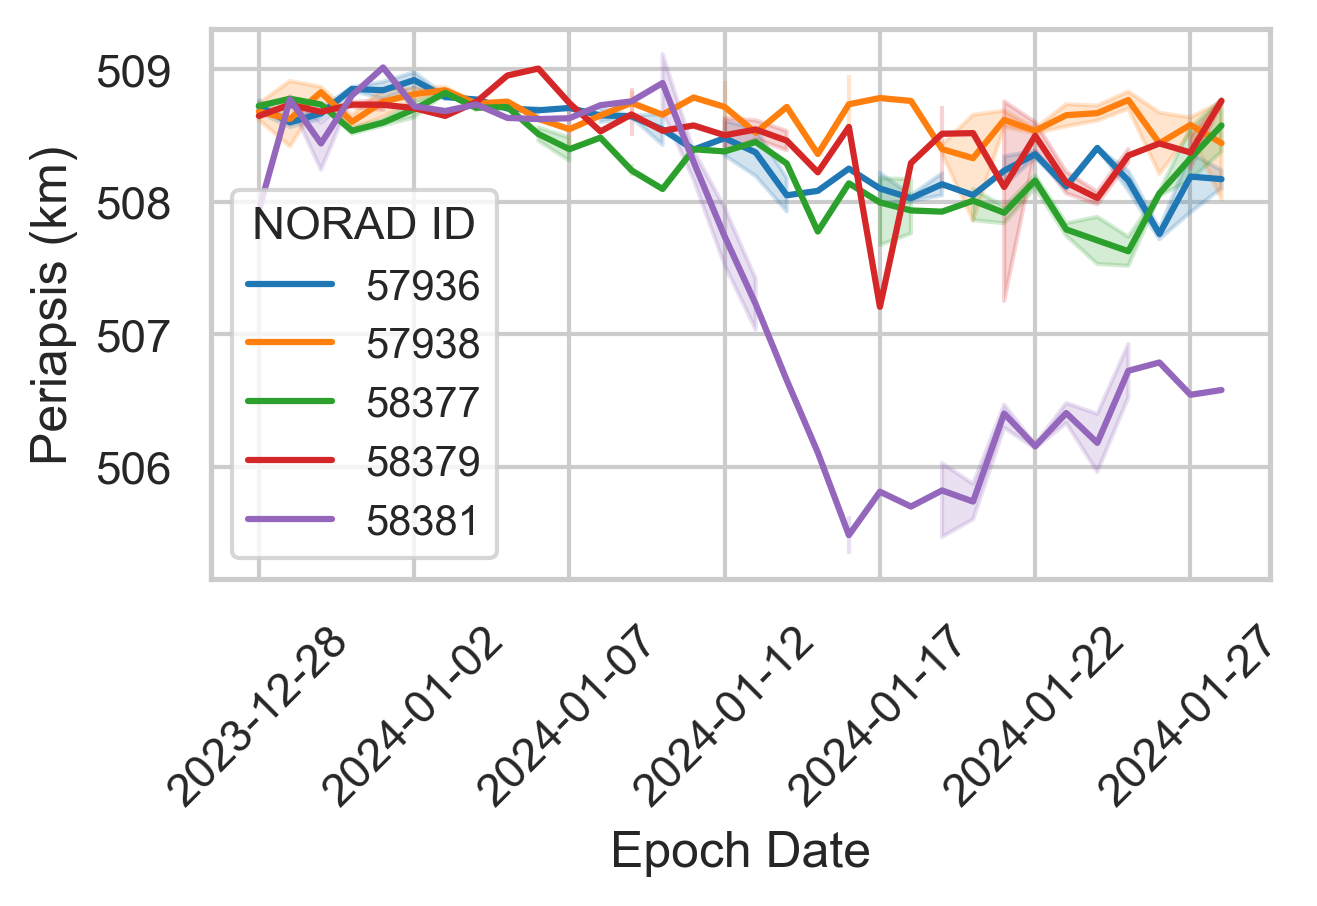

In [105]:
def filter_valid_satellites(df, num_satellites=1):
    """
    Filters and selects valid satellites based on data availability.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing satellite data with 'EPOCH_DATE' and 'NORAD_CAT_ID'.
    nodes_df (pd.DataFrame, optional): Additional DataFrame containing 'EPOCH_DATE'. Default is None.
    num_satellites (int, optional): Number of satellites to select. Default is 10.
    
    Returns:
    list: List of selected satellite NORAD_CAT_IDs.
    """
    # Ensure EPOCH_DATE is in datetime format
    df['EPOCH_DATE'] = pd.to_datetime(df['EPOCH_DATE'])

    # Identify satellites with sufficient data points
    all_dates = df['EPOCH_DATE'].unique()
    threshold = len(all_dates) // 2
    satellite_counts = df.groupby('NORAD_CAT_ID')['EPOCH_DATE'].nunique()
    valid_satellites = satellite_counts[satellite_counts > threshold].sort_values(ascending=False).index
    selected_sat_ids = valid_satellites[:num_satellites]
    return selected_sat_ids


def plot_numcol_evolution_day(df, column, sat_ids, unit='', log_scale=False, save_path='../figures/satcon/', figsize=(12, 6),
                              save=False, plot_title=True):
    # Prepare plot title and labels
    column_title = column.replace('_', ' ').title()
    title = f'Evolution of {column_title} per Day for Space Objects'

    # Filter data for selected satellites
    plot_data = df[df['NORAD_CAT_ID'].isin(sat_ids)]

    # Create plot
    plt.figure(figsize=figsize)
    if log_scale:
        plot_data[f'{column}_log'] = np.log(plot_data[column])
        column = f'{column}_log'
        column_title = f'log({column_title})'
    sns.lineplot(x='EPOCH_DATE', y=column, hue='NORAD_CAT_ID', data=plot_data, palette='tab10')
    if plot_title:
        plt.title(title)
    plt.xlabel('Epoch Date')

    if log_scale:
        column_title = f'log({column_title})'
    plt.ylabel(f'{column_title} ({unit})' if unit != '' else column_title)
    plt.xticks(df['EPOCH_DATE'].unique()[::5], rotation=45)

    # Place legend outside the plot area
    plt.legend(title='NORAD ID', fontsize=10, title_fontsize=11)
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Save the figure if requested
    if save:
        plt.savefig(f'{save_path}eda_satcon_{"_".join(title.lower().split())}.pdf', format='pdf')

    plt.show()


sat_ids = [58377, 58381, 57938, 57936, 58379]#filter_valid_satellites(df, num_satellites=5)
column = 'PERIAPSIS'
plot_numcol_evolution_day(df, column, sat_ids, unit=orbital_units[column], log_scale=column in log_scale_columns,
                          save_path='../figures/satcon/original_', plot_title=False, save=True, figsize=get_figsize(column_width, wf=0.9, hf=0.6))
# d = plot_numcol_evolution_day(nodes_df.reset_index(), column, sat_ids, unit=orbital_units[column], log_scale=column in log_scale_columns,
#                               save_path='../figures/graph_')

## Heatmap of Correlation Matrix

In [ ]:
nodes_df.columns

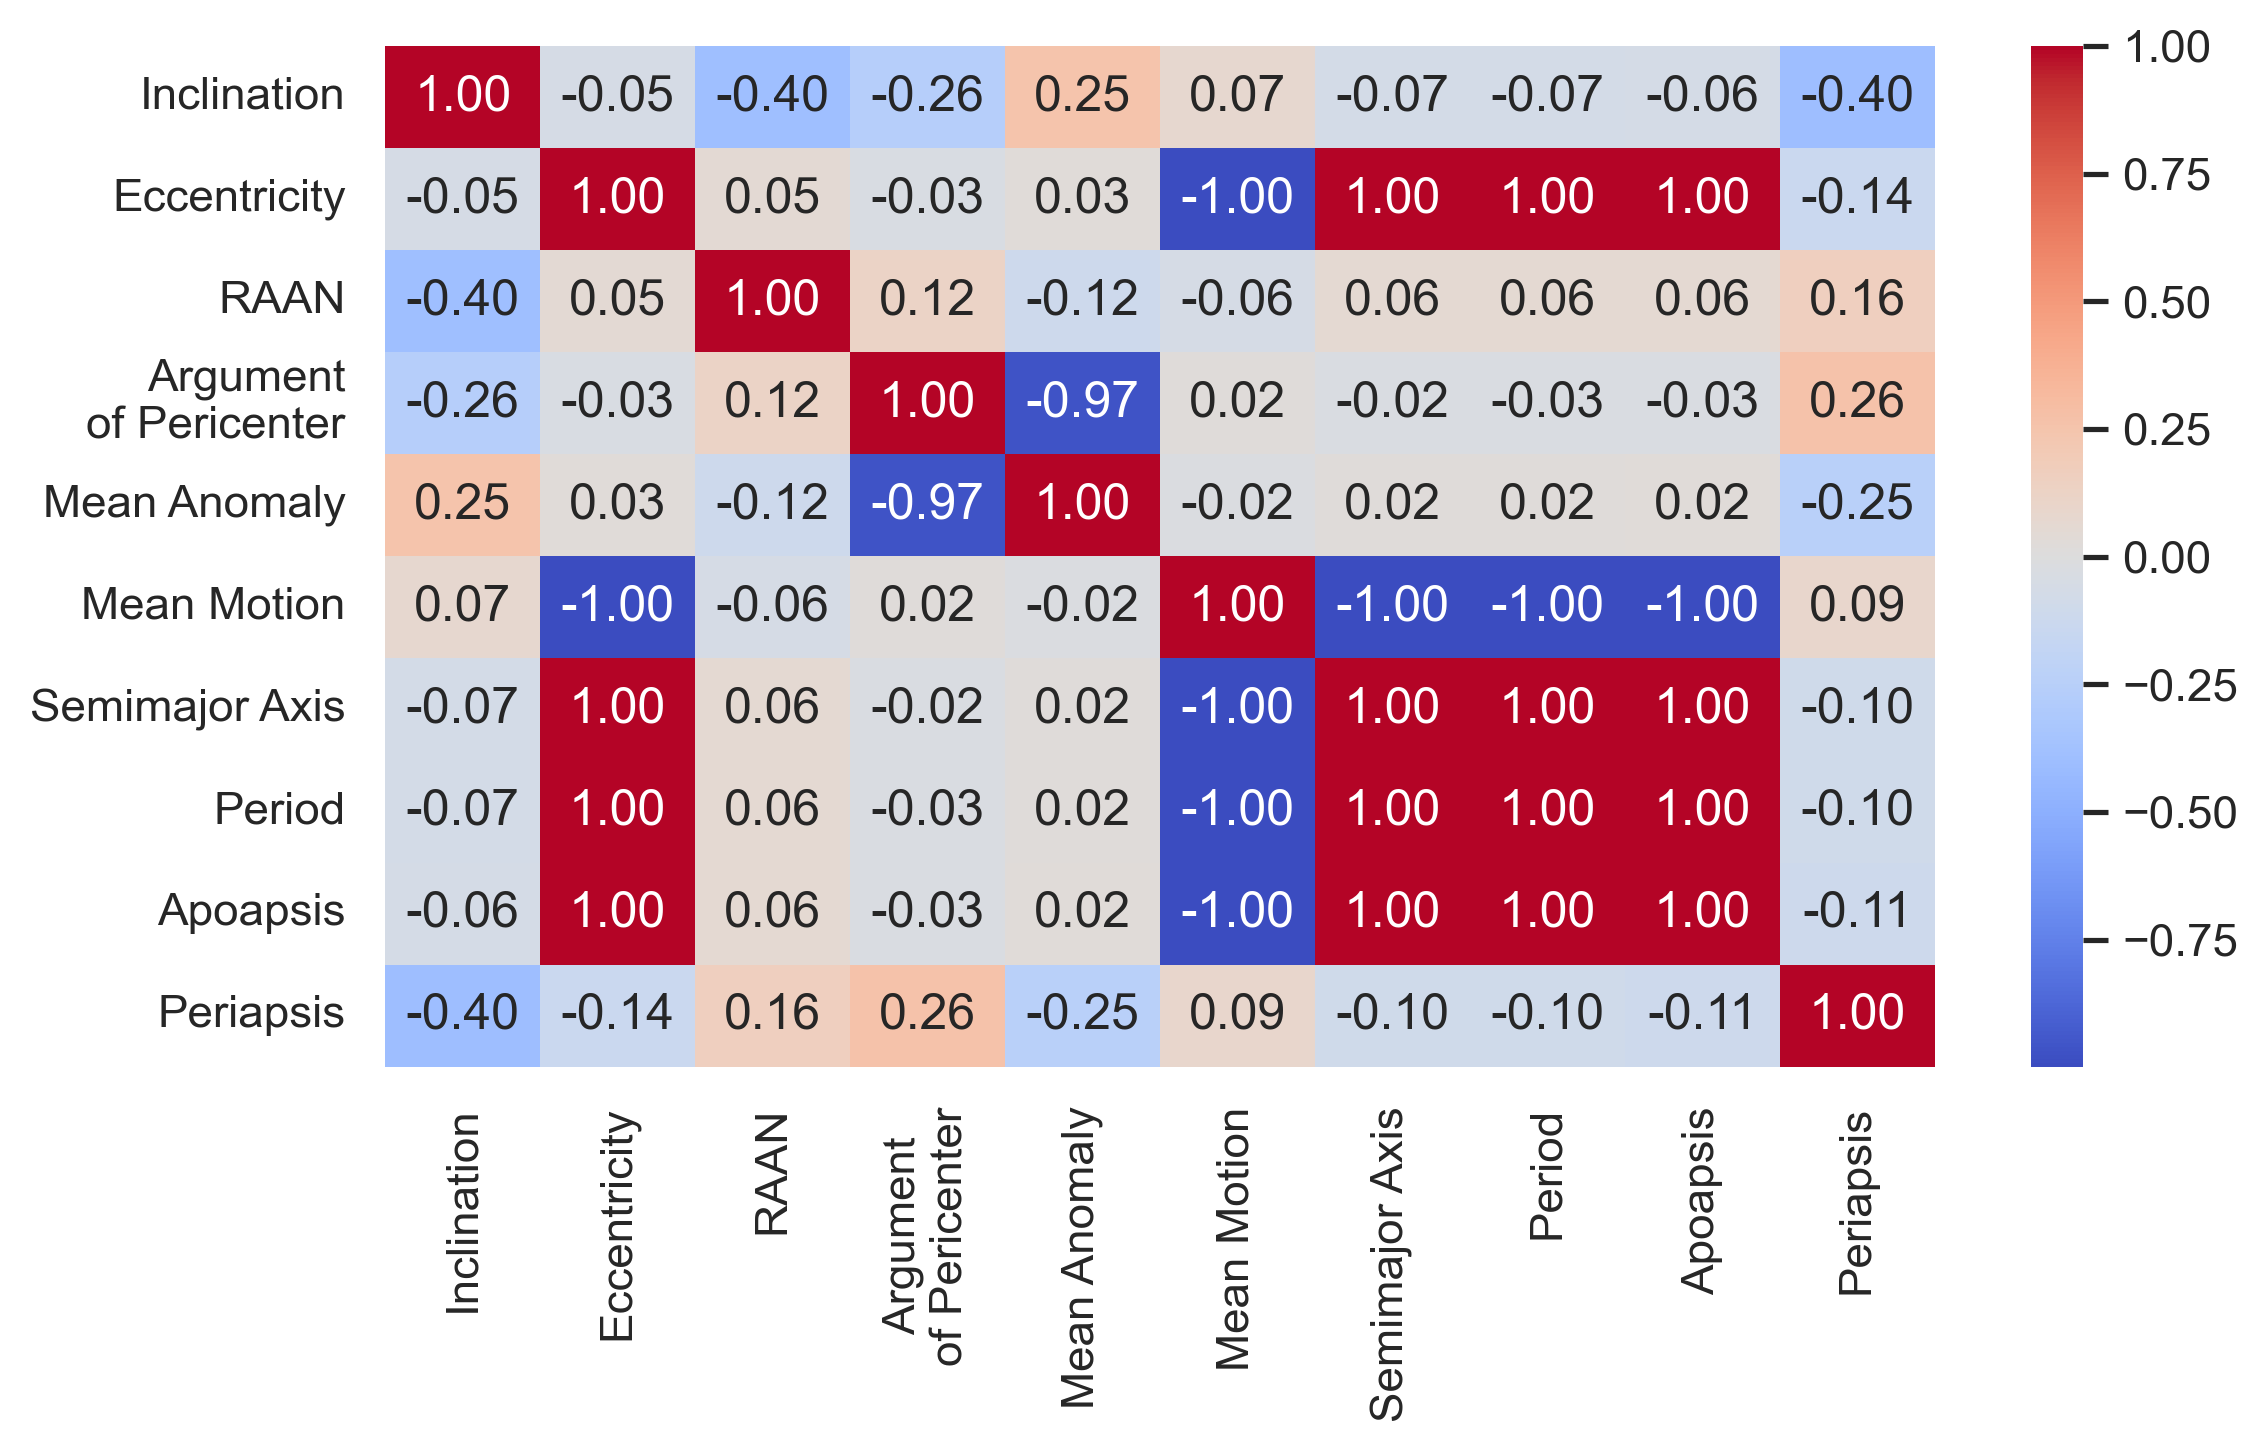

In [79]:
def plot_corr_heatmap(df, columns=None, rename_dict=None, title='Correlation Matrix of Orbital Parameters',
                      save_path='../figures/satcon/',
                      figsize=(8, 5), save=False, plot_title=True):
    # Use default columns if none provided
    if columns is None:
        columns = ['INCLINATION', 'ECCENTRICITY', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS']#, 'PX', 'PY', 'PZ', 'VX', 'VY', 'VZ']

    # Use default renaming if none provided
    if rename_dict is None:
        rename_dict = {
            'INCLINATION': 'Inclination',
            'ECCENTRICITY': 'Eccentricity',
            'RA_OF_ASC_NODE': 'RAAN',#'Right Ascension\nof Ascending Node',  # Split into two lines
            'ARG_OF_PERICENTER': 'Argument\nof Pericenter',  # Split into two lines
            'MEAN_ANOMALY': 'Mean Anomaly',
            'MEAN_MOTION': 'Mean Motion',
            'SEMIMAJOR_AXIS': 'Semimajor Axis',
            'PERIOD': 'Period',
            'APOAPSIS': 'Apoapsis',
            'PERIAPSIS': 'Periapsis'
            # 'PX': 'Position X',
            # 'PY': 'Position Y',
            # 'PZ': 'Position Z',
            # 'VX': 'Velocity X',
            # 'VY': 'Velocity Y',
            # 'VZ': 'Velocity Z'
        }

    # Set up the figure size
    plt.figure(figsize=figsize)

    # Select and rename the relevant columns
    df_renamed = df[columns].rename(columns=rename_dict)

    # Generate the correlation matrix
    correlation_matrix = df_renamed.corr()

    # Create the heatmap with annotations and a coolwarm color palette
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f')

    # Optionally add a title
    if plot_title:
        plt.title(title)

    # Adjust the layout
    plt.tight_layout()

    # Save the figure as a PDF if required
    if save:
        plt.savefig(f'{save_path}eda_satcon_{"_".join(title.lower().split())}.pdf', format='pdf')

    # Display the plot
    plt.show()


plot_corr_heatmap(df, plot_title=False, save=True)

## Pair Plot of Orbital Parameters

In [ ]:
plt.figure(figsize=(10, 6))
orbital_parameters = df[['INCLINATION', 'ECCENTRICITY', 'RA_OF_ASC_NODE', 'ARG_OF_PERICENTER']]
sns.pairplot(orbital_parameters)
title = 'Pair Plot of Orbital Parameters'
plt.suptitle(title, y=1.02)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

## Orbit plot of 5 random satellites

## Matplotlib

In [ ]:
# Select 5 random satellites
random_satellites = df[df['EPOCH_DATE'] == '2023-12-28'].sample(5)
random_satellites

In [ ]:
mu = 398600.4418
r = 6371.0
D = 24 * 0.997269
plot_earth = not True
polar_view = not False
fig = plt.figure()
ax = plt.axes(projection='3d', computed_zorder=False)
random_satellites["EPOCH_DATE"] = pd.to_datetime(random_satellites["EPOCH_DATE"])
for _, row in random_satellites.iterrows():
    orb = {}
    orb.update({"name": row["NORAD_CAT_ID"], "e": row["ECCENTRICITY"],
                "a": (mu / ((2 * m.pi * row["MEAN_MOTION"] / (D * 3600)) ** 2)) ** (1. / 3),
                "i": row["INCLINATION"] * m.pi / 180, "RAAN": row["RA_OF_ASC_NODE"] * m.pi / 180,
                "omega": row["ARG_OF_PERICENTER"] * m.pi / 180})
    orb.update({"b": orb["a"] * m.sqrt(1 - orb["e"] ** 2), "c": orb["a"] * orb["e"]})
    R = np.matmul(np.array(
        [[m.cos(orb["RAAN"]), -m.sin(orb["RAAN"]), 0], [m.sin(orb["RAAN"]), m.cos(orb["RAAN"]), 0], [0, 0, 1]]), (
        np.array(
            [[1, 0, 0], [0, m.cos(orb["i"]), -m.sin(orb["i"])], [0, m.sin(orb["i"]), m.cos(orb["i"])]])))
    R = np.matmul(R, np.array(
        [[m.cos(orb["omega"]), -m.sin(orb["omega"]), 0], [m.sin(orb["omega"]), m.cos(orb["omega"]), 0], [0, 0, 1]]))
    x, y, z = [], [], []
    for i in np.linspace(0, 2 * m.pi, 100):
        P = np.matmul(R, np.array([[orb["a"] * m.cos(i)], [orb["b"] * m.sin(i)], [0]])) - np.matmul(R, np.array(
            [[orb["c"]], [0], [0]]))
        x += [P[0]]
        y += [P[1]]
        z += [P[2]]
    ax.plot(x, y, z, zorder=5, label=orb["name"])
if plot_earth:
    u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
    ax.plot_wireframe(r * np.cos(u) * np.sin(v), r * np.sin(u) * np.sin(v), r * np.cos(v), color="b", alpha=0.5, lw=0.5,
                      zorder=0)
#plt.title("Orbit plot of 5 random satellites")
ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
ax.set_zlabel("z (km)")
ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7)
ax.zaxis.set_tick_params(labelsize=7)
ax.set_aspect('equal', adjustable='box')
if len(row) // 2 < 5:
    ax.legend()
else:
    fig.subplots_adjust(right=0.8)
    ax.legend(loc='center left', bbox_to_anchor=(1.07, 0.5), fontsize=7)

if polar_view:
    ax.zaxis.set_ticks([])
    ax.set_zlabel('')
    ax.view_init(elev=90, azim=-90, roll=0)
plt.tight_layout()
plt.savefig('../figures/Orbits_Plot_Polar.pdf', format='pdf')
ax.set_box_aspect(None, zoom=0.87)
plt.show()

In [ ]:
# [16456, 45160, 39075, 22185, 7164]

# Ground track map of the previous 5 random satellites

In [ ]:
random_satellites

In [ ]:
# Load the satellite TLE data into Skyfield
ts = load.timescale()
selected_satellites = []
for _, row in random_satellites.iterrows():
    line1 = row['TLE_LINE1']
    line2 = row['TLE_LINE2']
    name = str(row['NORAD_CAT_ID'])
    satellite = EarthSatellite(line1, line2, name=name, ts=ts)
    selected_satellites.append(satellite)

# Generate ground track points for each selected satellite
duration = ts.utc(2024, 1, range(1, 30))  # One year of data

# Generate ground track points for each satellite
ground_tracks = {}
for satellite in selected_satellites:
    positions = [satellite.at(t).subpoint() for t in duration]
    lats, lons = zip(*[(position.latitude.degrees, position.longitude.degrees) for position in positions])
    ground_tracks[satellite.model.satnum] = {'lat': lats, 'lon': lons}

# Use the tab10 color palette
colors = pcolors.qualitative.T10  # tab10 color palette from plotly

# Create the ground track map with legends
fig = px.line_geo(title='Ground Tracks of 5 Satellites', labels={'lon': 'Longitude', 'lat': 'Latitude'},
                  template='seaborn')

for i, (satnum, data) in enumerate(ground_tracks.items()):
    color = colors[i % len(colors)]  # Ensure cycling through colors if more than 10 satellites
    fig.add_scattergeo(lon=data['lon'], lat=data['lat'], mode='lines', line_color=color, name=f'Satellite {satnum}')
#fig.write_image('../figures/ground_track_map.pdf')
# Show the map
fig.show()